In [1]:
import torch.nn as nn
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from transformer import SpaceTimeFormer
import torch
import datetime as dt

C:\Users\Haris\anaconda3\envs\Transformers_Project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def download_data(TICKER, START_DATE, END_DATE):
    data = yf.download(TICKER, start= START_DATE, end = END_DATE)
    data = data['Close']
    return data

date_start = '2021-01-03'
date_end = '2022-12-03'

#Stocks
ticker = {
    'S&P500': '^GSPC',
    'UnitedHealth Group': 'UNH',
    'Goldman Sachs': 'GS',
    'Home Depot': 'HD',
    'Amgen': 'AMG',
    'McDonalds': 'MCD',
    'Microsoft': 'MSFT'
}

#load data
df = pd.concat([download_data(name, date_start, date_end) for name in ticker.values()], axis=1)

#rename columns
df.set_axis([name for name in ticker.keys()], axis=1, copy=True)

#calculate returns
df = df.pct_change(1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
datetime = df.index
df = df.to_numpy().transpose()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
np.shape(df)

(7, 483)

In [4]:
''' Run only if you change tickers '''

# def create_sectors_list(ticker):
#     res = []
#     temp = {}
#     counter = 1
#     for stock, ticker in ticker.items():
#         try:
#             sec = yf.Ticker(ticker).info['sector']
#             if sec in temp:
#                 res.append(temp[sec])
#             else:
#                 temp[sec] = counter
#                 res.append(temp[sec])
#                 counter +=1
#         except:
#             continue
#     return res

# sectors_list = create_sectors_list(ticker)

' Run only if you change tickers '

In [5]:
sectors_list = [1,2,3,2,3,4]

In [6]:
sequence_souce = df[1:, :]
sequence_target = df[0, :].reshape(1,-1)

In [7]:
split = 0.7
pred_window = 1
seq_length = 5
datetime_train = datetime[:int(split*len(datetime))]
datetime_test = datetime[int(split*len(datetime)):]
sequence_source_train = sequence_souce[:, :int(np.shape(sequence_souce)[1]*split)]
sequence_source_test = sequence_souce[:, int(np.shape(sequence_souce)[1]*split):]
sequence_target_train = sequence_target[:, :int(np.shape(sequence_target)[1]*split)]
sequence_target_test = sequence_target[:, int(np.shape(sequence_target)[1]*split):]

In [8]:
## Scaling ###
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(np.transpose(sequence_source_train))
sequence_source_train = np.transpose(scaler.transform(np.transpose(sequence_source_train)))
sequence_source_test = np.transpose(scaler.transform(np.transpose(sequence_source_test)))

In [9]:
model = SpaceTimeFormer(pred_offset = pred_window,
                        input_size = 6,
                        output_size = 1,
                        seq_length = seq_length,
                        sectors_list = sectors_list,
                        datetime_index = datetime,
                        embedding_size_time = 3,
                        embedding_size_variable = 3,
                        embedding_size_sector = 3)

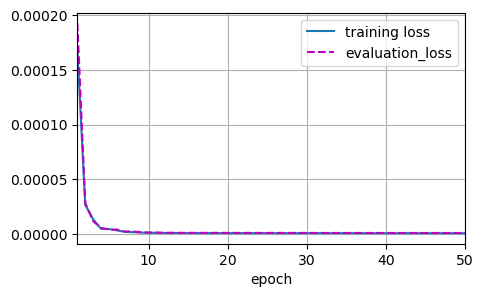

In [10]:
model.start_training(source=sequence_source_train,
                     target=sequence_target_train,
                     loss=nn.MSELoss(),
                     metric=nn.MSELoss(),
                     epochs=50,
                     batch_size=64,
                     learning_rate=1e-3,
                     standardize=False,
                     verbose=False,
                     plot=True)

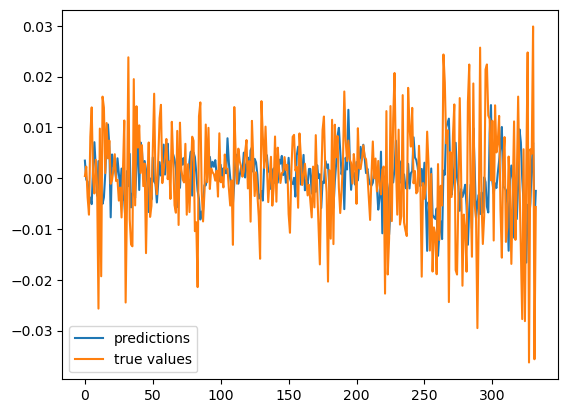

In [11]:
standardize = False
source = sequence_source_train
target = sequence_target_train

if standardize:
    scaler = preprocessing.MinMaxScaler().fit(source.transpose())
    source = scaler.transform(source.transpose()).transpose()
    scaler = preprocessing.MinMaxScaler().fit(target.transpose())
    target = scaler.transform(target.transpose()).transpose()

l = np.shape(sequence_source_train)[1]
y_hat = np.zeros((1,l))
y = target

src_idx_1, src_idx_2 = 0, 0
trg_idx_1, trg_idx_2 = 1, 1

while trg_idx_2 < l:
    src_idx_2 = src_idx_1 + seq_length
    trg_idx_2 = trg_idx_1 + seq_length + pred_window - 1
    
    src = source[:, src_idx_1:src_idx_2]
    trg_stub = target[:, trg_idx_1:trg_idx_2-pred_window]
    y_hat[0, trg_idx_2-pred_window:trg_idx_2] = model.predict(src, trg_stub, False)
    
    src_idx_1 += pred_window
    trg_idx_1 += pred_window

plt.plot(y_hat[0,seq_length:], label = 'predictions')
plt.plot(y[0,seq_length:],label = 'true values')
plt.legend()
plt.show()

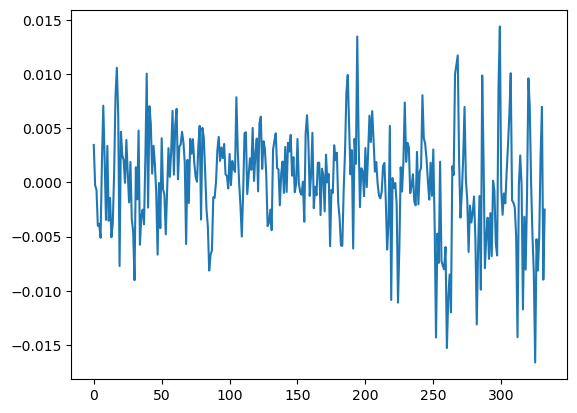

In [12]:
plt.plot(y_hat[0,seq_length:], label = 'predictions')
plt.show()